## Problem to solve

We consider the following DPE :
$$
    \frac{\partial ²u}{\partial t²} = \frac{T}{\mu} \frac{\partial ²u}{\partial x²} 
$$
and its boundary conditions : 
$$
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \forall t > 0, \; u(x=0, t) = 0 \;\; (1)\\
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \forall t > 0, u(x=L, t) = 0 \;\; (2)\\
and \;\; for \;\; t=0, \;\;\;\;\;\; u(x, 0) = Acos(2\pi\frac{x}{\lambda}) \;\;\;\;\;\; (3)
$$
where $\lambda$ is the wave length and A is the maximum positive value reach by the string.  
  
To solve this equation, we'll use a PINN.
We define $f(t,x)$ as $f := \frac{\partial ²u}{\partial t²} - \frac{T}{\mu} \frac{\partial ²u}{\partial x²}, \;$ u the approximated function.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from math import pi

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Model

In [2]:
class vanilla_PINN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, nof_hidden_layers):
        super().__init__()

        # To avoid bad entry: the inputs are x and t and the output is a scalar 
        try:

            if input_size != 2:
                raise ValueError("Input size must be equal to 2")

            elif output_size != 1:
                raise ValueError("Output size must be equal to 1")

            self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.GELU())
            self.output_layer = nn.Linear(hidden_size, output_size)

        except ValueError as error:
            print(error)
            return None

        # To be flexible on the number of hidden layers when instanciate the NN
        self.hidden_layers = nn.Sequential()

        for i in range(nof_hidden_layers):
            self.hidden_layers.add_module("hidden_layer_" + str(i), nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.add_module("GELU_" + str(i), nn.GELU())


    def forward(self, t, x):
        
        V = torch.cat([t, x], dim=1)
        V = self.input_layer(V)
        V = self.hidden_layers(V)
        V = self.output_layer(V)
        
        return V

## Utils

In [3]:
# Define Partial Derivative Equation (PDE) as a one of the loss
def f(t, x, neural_net, pb_params_list):
    """
        (from the problem) PDE : u_tt - (T / mu) * u_xx
        pb_params_list = [T, mu]
    """

    u    = neural_net(t, x)
    
    #d²u/dx² = u_xx 
    u_x  = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    
    # d²u/dt² = u_tt
    u_t  = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_tt = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

    PDE = u_tt - (pb_params_list[0] / pb_params_list[1]) * u_xx

    return PDE


# Loss function on boundary conditions points
def MSE_loss(groung_truth_pts, net_output_pts):
    mse_bc = nn.MSELoss()
    return mse_bc(groung_truth_pts, net_output_pts)


def train(model, nof_collocations_pts,
          x_bc1_pts, t_bc1_pts, u_bc1_pts,
          x_bc2_pts, t_bc2_pts, u_bc2_pts,
          x_bc3_pts, t_bc3_pts, u_bc3_pts,
          pb_params_list,
          optimizer, nof_iterations, 
          device):

    training_loss = []

    for epoch in range(nof_iterations):

        model.train()
        optimizer.zero_grad()

        #Loss on first BC (u(x=0, t) = 0 for all t)
        x_bc1_pts = Variable(x_bc1_pts, requires_grad=False).to(device)
        t_bc1_pts = Variable(t_bc1_pts, requires_grad=False).to(device)
        u_bc1_pts = Variable(u_bc1_pts, requires_grad=False).to(device)

        net_output_bc1 = model(t_bc1_pts, x_bc1_pts)
        mse_u_bc1      = MSE_loss(u_bc1_pts, net_output_bc1)

        #Loss on second BC (u(x=L, t) = 0 for all t)
        x_bc2_pts = Variable(x_bc2_pts, requires_grad=False).to(device)
        t_bc2_pts = Variable(t_bc2_pts, requires_grad=False).to(device)
        u_bc2_pts = Variable(u_bc2_pts, requires_grad=False).to(device)

        net_output_bc2 = model(t_bc2_pts, x_bc2_pts)
        mse_u_bc2      = MSE_loss(u_bc2_pts, net_output_bc2)

        #Loss in third BC (u(x, t=0) = u_max * cos(2 * pi * x / lambda) for all x and where lambda is the wave length)
        x_bc3_pts = Variable(x_bc3_pts, requires_grad=False).to(device)
        t_bc3_pts = Variable(t_bc3_pts, requires_grad=False).to(device)
        u_bc3_pts = Variable(u_bc3_pts, requires_grad=False).to(device)

        net_output_bc3 = model(t_bc3_pts, x_bc3_pts)
        mse_u_bc3      = MSE_loss(u_bc3_pts, net_output_bc3)

        # PDE loss : collocations points form an equally spaced (t,x)-grid where x_max = L
        L     = x_bc2_pts.data[0].item()
        t_max = torch.max(t_bc1_pts).item()

        x_collocation_pts = torch.linspace(0, L, nof_collocations_pts)
        x_collocation_pts = x_collocation_pts.reshape(x_collocation_pts.shape[0], 1)
        x_collocation_pts = Variable(x_collocation_pts, requires_grad=True).to(device)

        t_collocation_pts = torch.linspace(0, t_max, nof_collocations_pts)
        t_collocation_pts = t_collocation_pts.reshape(t_collocation_pts.shape[0], 1)
        t_collocation_pts = Variable(t_collocation_pts, requires_grad=True).to(device)

        f_output = f(t_collocation_pts, x_collocation_pts, model, pb_params_list)
        mse_pde  = MSE_loss(f_output, torch.zeros_like(f_output))

        #Compute loss as the sum of all cost
        total_running_loss = mse_u_bc1 + mse_u_bc2 + mse_u_bc3 + mse_pde
        training_loss.append(total_running_loss.detach().to('cpu'))

        total_running_loss.backward()
        optimizer.step()

        with torch.autograd.no_grad():
            print('Epoch: {} | training loss: {:.12f}'.format(epoch, total_running_loss))

    return training_loss


## Main

Epoch: 0 | training loss: 1.299397110939
Epoch: 1 | training loss: 1.283812522888
Epoch: 2 | training loss: 1.268445968628
Epoch: 3 | training loss: 1.253298759460
Epoch: 4 | training loss: 1.238372802734
Epoch: 5 | training loss: 1.223669648170
Epoch: 6 | training loss: 1.209188103676
Epoch: 7 | training loss: 1.194929838181
Epoch: 8 | training loss: 1.180895209312
Epoch: 9 | training loss: 1.167083382607
Epoch: 10 | training loss: 1.153494954109
Epoch: 11 | training loss: 1.140128374100
Epoch: 12 | training loss: 1.126984119415
Epoch: 13 | training loss: 1.114060401917
Epoch: 14 | training loss: 1.101356387138
Epoch: 15 | training loss: 1.088869810104
Epoch: 16 | training loss: 1.076599597931
Epoch: 17 | training loss: 1.064544677734
Epoch: 18 | training loss: 1.052701950073
Epoch: 19 | training loss: 1.041069626808
Epoch: 20 | training loss: 1.029644966125
Epoch: 21 | training loss: 1.018425941467
Epoch: 22 | training loss: 1.007410287857
Epoch: 23 | training loss: 0.996594190598
Ep

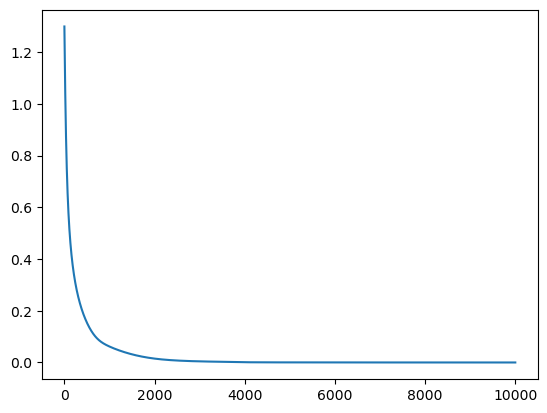

In [6]:
if __name__=="__main__":
    
    # Model
    input_size        = 2
    hidden_size       = 5
    output_size       = 1
    nof_hidden_layers = 5

    pinn = vanilla_PINN(input_size, hidden_size, output_size, nof_hidden_layers)
    pinn = pinn.to(device)
    
    # Problem params (nylon string)
    T     = 50   #Newton
    mu    = 8e-4 #kg/meter
    ro    = 950  #kg/m³ (volumic mass)
    d     = 1e-3 #meter (diameter of the string) 
    L     = 10 #meter (length of the string)
    u_max = 1e-3 #meter
    t_max = 1000   #seconds
    lbda  = 1e-2 #meter (wave length at t=0)

    nof_pts = 10000

    # Setting first BC (u(x=0, t) = 0 for all t)
    x_bc1_pts = torch.zeros((nof_pts, 1))
    t_bc1_pts = torch.linspace(0, t_max, nof_pts)
    t_bc1_pts = t_bc1_pts.reshape(t_bc1_pts.shape[0], 1)
    u_bc1_pts = torch.zeros((nof_pts, 1))

    #Setting second BC (u(x=L, t) = 0 for all t)
    x_bc2_pts = L + torch.zeros((nof_pts, 1))
    t_bc2_pts = torch.linspace(0, t_max, nof_pts)
    t_bc2_pts = t_bc2_pts.reshape(t_bc2_pts.shape[0], 1)
    u_bc2_pts = torch.zeros((nof_pts, 1))

    #Setting third BC (u(x, t=0) = u_max * cos(2 * pi * x / lambda) for all x and where lambda is the wave length)
    x_bc3_pts = torch.linspace(0, L, nof_pts)
    x_bc3_pts = x_bc3_pts.reshape(x_bc3_pts.shape[0], 1)
    t_bc3_pts = torch.zeros((nof_pts, 1))
    u_bc3_pts = u_max * torch.cos(2 * pi * x_bc3_pts / lbda)
    u_bc3_pts = u_bc3_pts.reshape(u_bc3_pts.shape[0], 1)

    # Training
    model                = pinn
    pb_params_list       = [T, mu]
    nof_collocations_pts = 10000
    learning_rate        = 0.0001
    optimizer            = torch.optim.Adam(pinn.parameters(), lr=learning_rate)
    nof_iterations       = 10000

    training_loss = train(pinn, nof_collocations_pts,
                          x_bc1_pts, t_bc1_pts, u_bc1_pts,
                          x_bc2_pts, t_bc2_pts, u_bc2_pts,
                          x_bc3_pts, t_bc3_pts, u_bc3_pts,
                          pb_params_list,
                          optimizer, nof_iterations, 
                          device)

    #Plot training loss
    plt.plot(training_loss)
  
    #Save the model
    torch.save(pinn.state_dict(), 'pinn_model_stringvib.pt')

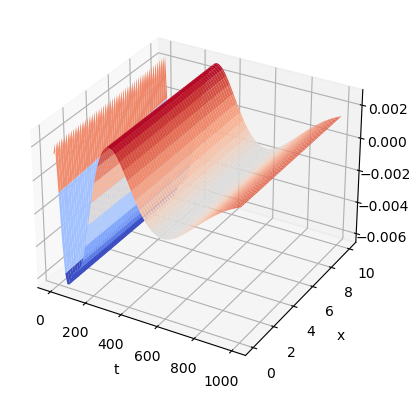

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Plot inference
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

nof_pts = 100

x_axis = np.linspace(0, L, nof_pts)
t_axis = np.linspace(0, t_max, nof_pts)
ms_t, ms_x = np.meshgrid(t_axis,x_axis, sparse=False)

pts_x = ms_x.reshape(-1, 1)
pts_t = ms_t.reshape(-1, 1)

pts_x = Variable(torch.from_numpy(pts_x).float(), requires_grad=True).to(device)
pts_t = Variable(torch.from_numpy(pts_t).float(), requires_grad=True).to(device)

pts_u = model(pts_t, pts_x)
ms_u = pts_u.to('cpu').detach().numpy()
ms_u = ms_u.reshape(ms_x.shape, order='C')

surface = ax.plot_surface(ms_t, ms_x, ms_u, 
                          cmap=cm.coolwarm, linewidth=0)#, antialiased=False)

plt.axis('auto')
ax.set_xlabel("t")
ax.set_ylabel("x")
plt.show()



## Interpretation

My neural network makes a lot of mistakes :
- where $x$ is equal to $0$ or $L$, $u(x,t)$ must be equal to $0$ but it's not the case here ;
- if the curve was right, we shouldn't see for a fixed $t$ that for the all the $x$, $u(x,t)$ is constant.

Those errors seem to come from the boundary conditions because we have a superpositions of conditions. It's a contradiction!

Ideas to apply after debug:
- try to apply weights to loss functions on boundary conditions
